# **case study**

# Image classification with convolutional neural network in PyTorch

Image classification is a classical and core task in computer vision, which has a large variety of practical applications. With the advent of deep learning, in combination with robust AI hardware and GPUs, outstanding performance has been achieved on image classification tasks. Thus, in this tutorial, we will use a convolutional neural network to do image classification using the PyTorch framework.

**After this tutorial you will be able to:**
- Understand pipeline of image classification
- Get the gist of powerful performance of CNNs
- Implement an easy-to-use CNN to do the image classification

https://github.com/pytorch/examples/blob/main/mnist/main.py

## 1.1 - Python preparation
### Install packages

In [ ]:
# install dependencies
# !pip install numpy torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch
!pip install matplotlib
!pip install tqdm
!pip install sklearn

### Import packages

In [ ]:
import numpy as np  # numerical calculations in python
import matplotlib.pyplot as plt  # plotting similar to matlab
import torch  # PyTorch: the general machine learning framework in Python
import torch.optim as optim  # contains optimizers for the backpropagation
import torch.nn as nn  # the artificial neural network module in PyTorch
import torchvision  #Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations.
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm  # produces progress bars for for-loops in Python

### Set the seed

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

## 1.2 - Prepare datasets
MNIST stands for Modified National Institute of Standards and Technology and is a database of 60,000 small square 28x28 pixel grayscale images. MNIST handwritten digits dataset is the most used for learning Image Recognition. It is labeled in the sense that each image of a handwritten digit has the corresponding numeral value attached to it. This helps our Algorithm/Neural Network to learn which image stands for which number (0-9) and to learn hidden patterns in human writing.


###Download the dataset

*   Training dataset: 60000 images and 10 categories
*   Test dataset: 10000 image sand 10 categories


In [ ]:
# # Loading Data and splitting it into train and validation data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
trainset = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
#Loading test dataset
testset = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000)


###Visualize the dataset 
10 images from each classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


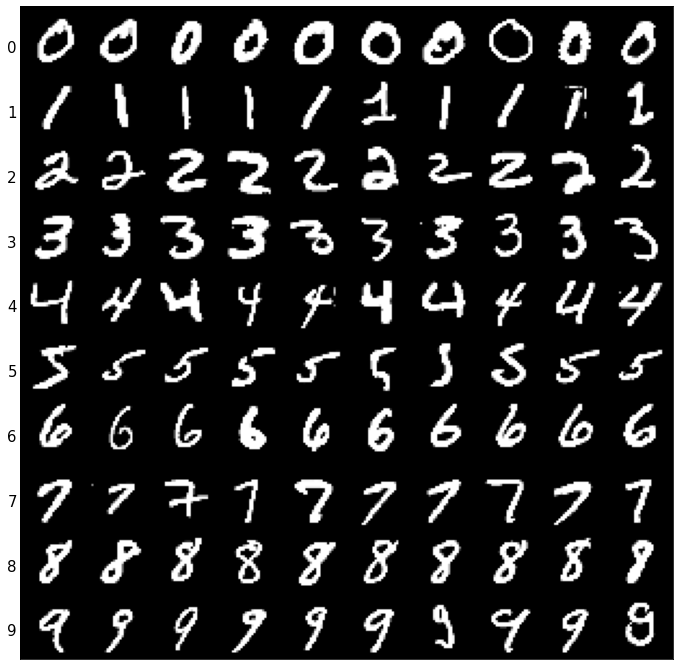

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.yticks([18 + i*30 for i in range(len(classes))], classes, fontsize=15)
    plt.xticks([])
    plt.tick_params(length=0)
    plt.show()

# get 10 training images of each class
classes = [0,1,2,3,4,5,6,7,8,9]
images = []
for class_ in classes:
    for image, label in trainset:
        if label == class_:
            images.append(image)
        if len(images) == (class_ + 1)*10:
            break

# show images
imshow(torchvision.utils.make_grid(images, nrow=10, padding=2))

## 1.3 - Set up a convolutional neural network
The general convolutional neural networks contain convolutional layers, pooling layers and fully-connected layers. PyTorch provides the framework for building CNNs. The *nn.Module* is the standard class for CNN in PyTorch. The abbreviation *nn* stands for the neural network. We build a child class of it where we specify our desired model architecture. Pytorch uses a base model object and adds the layers and activations as other objects in a sequential manner. The first layer must get input dimensions matching the data, whereas the following can deduce their input size from the previous layer. The output layer then must match the dimension of the target values. **For the images, the input dimensions are usually 1 for greyscales image and 3 for RGB images.** Each CNN class needs a *forward* function which defines, how a signal propagates through the network.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input layer: convolutional layer
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)
        self.relu1 = nn.ReLU(inplace = True)
        #Hidden layer: convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)
        self.relu2 = nn.ReLU(inplace = True)
        #Pooling layer
        self.max_pool = nn.MaxPool2d(kernel_size = 2)
        #Fully-connetced layer 
        self.fc1 = nn.Linear(in_features = 9216, out_features = 128)
        self.relu3 = nn.ReLU(inplace = True)
        self.fc2 = nn.Linear(in_features = 128, out_features = 10)

    def forward(self, x):
        result_first_conv = self.conv1(x)
        result_first_relu = self.relu1(result_first_conv)
        result_second_conv = self.conv2(result_first_relu)
        result_second_relu = self.relu2(result_second_conv)
        result_pooling = self.max_pool(result_second_relu)
        x = torch.flatten(result_pooling, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output, result_first_conv,result_second_conv, result_first_relu,result_second_relu,result_pooling 

## 1.4 - Train CNN
Now the fun begins. We put the dataset and CNN architecture together to "train" our CNN.

We use the training data to train our neural network. This process is nothing else then optimizing the weights and biases in our network. Before starting the training process, we need to define a few things:
- *optimizer*: Here we use *AdaDelta*. AdaDelta is a stochastic optimization technique that allows for per-dimension learning rate method for stochastic gradient descent. With the optimizer, we also need to define the learning rate *lr*. It determines how fast we adopt the weights and biases during the training. If it is too high, the learning becomes instable and the loss increases. If it is too low, we need to many epochs and we do not reach a satisfying precision.
- *loss function*: This is the objective of our training/optimization. Here we use cross entropy for classification problem.
- *epochs*: How often do we want to repeat the training with our dataset?

Optimizing these parameters is called hyerparameter tuning.

In [ ]:
model = Net()# create neural network
optimizer = optim.Adadelta(model.parameters(), lr=1)   # choose optimizer and learning rate
loss_function = nn.CrossEntropyLoss() # define loss function
epochs = 1 # set number of epochs
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

This is the main part of using a CNN: the actual "training". We give an input to the network and see how the output differs from our expected output. The difference is used to calculate the loss. Then we update the weights and biases such that the loss will be smaller in the next epoch.

In [ ]:

def train(num_epochs, net, trainloader, optimizer, loss_function):
    
    net.train()
        
    # Train the model
    for epoch in range(num_epochs):

        for batch_idx, (data, target) in enumerate(train_loader):
            
  
            # clear gradients for this training step   
            optimizer.zero_grad()  

            # forward pass: prediction y based on input x
            output,_,_,_,_,_ = net(data)

            # compare true y and predicted y to get the loss             
            loss = loss_function(output, target)
                     
            
            # backpropagation, compute gradients 
            loss.backward()  
      
            # apply gradients             
            optimizer.step()                
          
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
train(epochs, model, train_loader, optimizer,loss_function)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301136
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.210059
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.480682
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.335372
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.331343
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.139159
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.134984
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.206357
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.269311
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.117215
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.109212
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.196672
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.108422
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.069531
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.138390
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.037845
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.178363
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.074687
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.294208
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.070643
Train Epoch: 1 [12800/60000 (

## 1.5 - Evaluate CNN

**Accuracy of test dataset**

First, we use a test dataset to evaluate our trained CNN and to calculate the overall accuracy for all numbers.

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output,_,_,_,_,_ = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
test(model, test_loader)


Test set: Accuracy: 9852/10000 (99%)



**Intermediate result**

How did our CNN model process this image? What actually happens within the CNN model? To help you understand the whole process, let's discover the intermediate results in the neural network.

First we select one image as example:

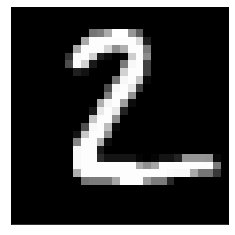

In [149]:
plt.imshow(testset[1][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Next, we plot **first six channels** after **first convolutional layer, first activation layer, second convolutional layer, second activation layer and max pooling layer**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


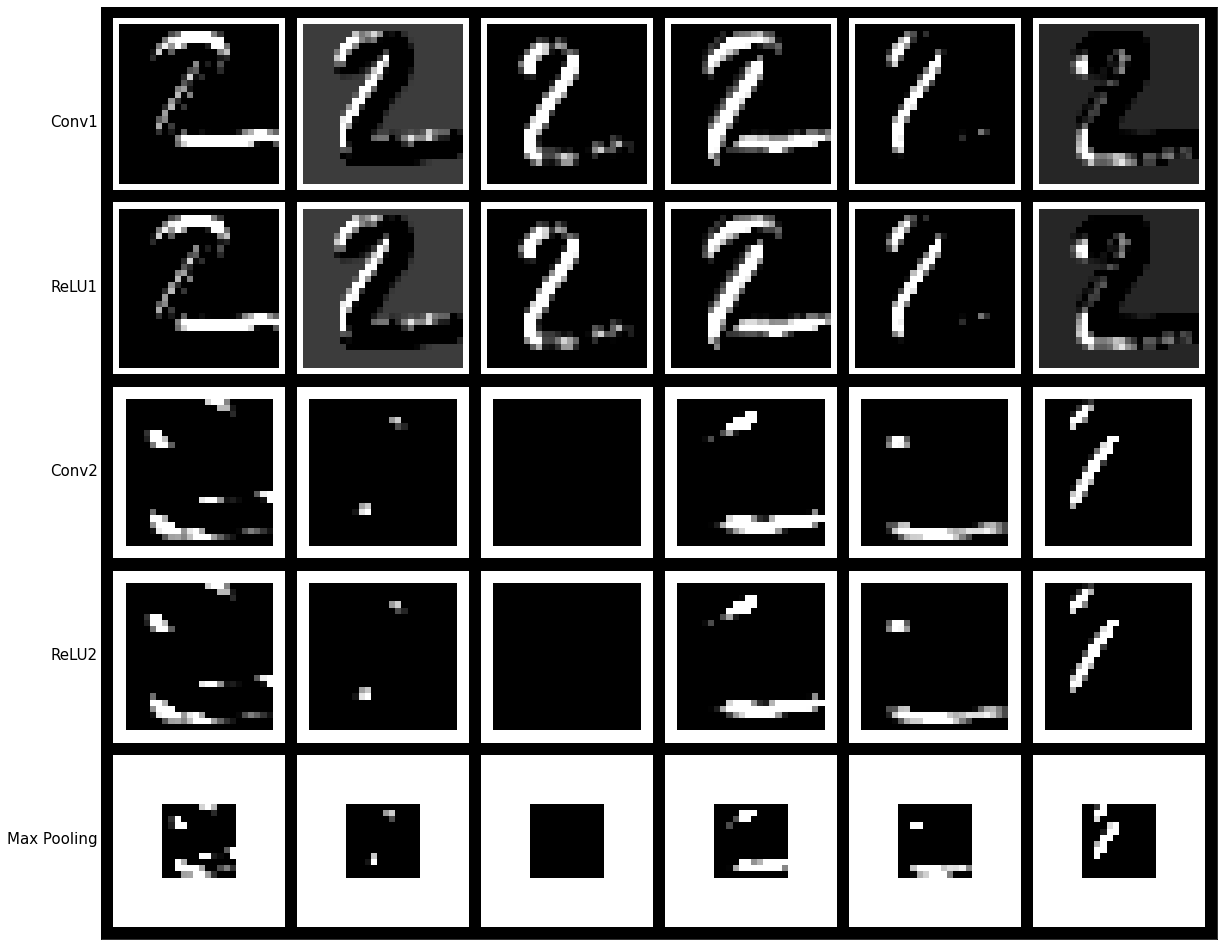

In [150]:
def plot_image(image,model):
  image_list = [ ]
  _, first_conv, second_conv, first_relu, second_relu, pooling = model(image[1][0].reshape(1,1,28,28))
  for layer in [first_conv, first_relu, second_conv, second_relu, pooling]:
    for number in range(6):
      image_example = layer[0][number].reshape(layer.shape[-1],layer.shape[-1])
      pad_number = int((28 - image_example.shape[-1])/2)
      pad = nn.ConstantPad2d(padding=(pad_number, pad_number, pad_number, pad_number), value=1)
      image_after_padding = pad(image_example)
      # print(image_after_padding.shape)
      image_list.append(image_after_padding.reshape(1,28,28))

  img = torchvision.utils.make_grid(image_list, nrow=6,ncol=5, padding=2)
  npimg = img.numpy()
  plt.figure(figsize=(20, 20))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.yticks([18, 45, 75, 105, 135], ['Conv1', 'ReLU1', 'Conv2', 'ReLU2', 'Max Pooling'], fontsize=15)
  plt.xticks([])
  plt.tick_params(length=0)
  plt.show()
  return image_list
image_list = plot_image(testset,model)


**Discussion**

We can see that in the early stage of convolutional layer, CNN uses different filters to get the simple features such as edges and corners. More complex and abstract patterns appear with further concolutional layers. And the pooling layer helps to reduce the spatial dimension and keep the most important features.   

## 1.6 - Conclusion
In the second lab we demonstrated how to use a CNN for image classification. We introduced how to set up a CNN for image classification and how to evaluate the result. We also discussed how the CNN process our images within the model.

We hope you enjoyed it!